Trying to fit celerite gaussian processes

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
import autograd
import celerite
from celerite import terms
import scipy.optimize as op
from scipy.optimize import minimize


In [2]:
train = pd.read_csv('../input/training_set.csv')
train_meta = pd.read_csv('../input/training_set_metadata.csv')
train = train.merge(train_meta[['object_id', 'target']], how='left', on='object_id')

In [11]:
def fit_predict_celerite(train, object_id, expand=True):
    df0 = train[train.object_id == object_id]
    fig, ax = plt.subplots(1, 1, figsize =(15, 5))
    colors = ['C4', 'C2','C3','C1','k','C5']
    offset = 11
    x_min = df0.mjd.min()
    x_max = df0.mjd.max()
    for pb in range(6):
        df = df0[(df0.object_id == object_id) & (df0.passband == pb)]
        yerr = df.flux_err
        yerr_std = yerr.std()
        yerr_mean = yerr.mean()
        df = df[yerr <= yerr_mean + 5 * yerr_std]
        mjd_delta_prev = (df.mjd - df.mjd.shift(1)).fillna(100).values.ravel()
        mjd_delta_next = (df.mjd.shift(-1) - df.mjd).fillna(100).values.ravel()
        yerr_mean = df.flux_err.mean()
        x = df.mjd.values
        y = df.flux.values
        yerr = df.flux_err
        if expand:
            mjd_delta_prev = np.concatenate((100 * np.ones((offset,)),
                                mjd_delta_prev,
                                100 * np.ones((offset,)),
                              ))
            mjd_delta_next = np.concatenate((100 * np.ones((offset,)),
                                mjd_delta_next,
                                100 * np.ones((offset,)),
                              ))
            x = np.concatenate((np.linspace(x_min-250, x_min -200, offset),
                                x,
                                np.linspace(x_max+200, x_max+250, offset),
                              ))
            y = np.concatenate((np.random.randn(offset) * yerr_mean,
                                y,
                                np.random.randn(offset) * yerr_mean
                               ))
            yerr = np.concatenate((yerr_mean * np.ones(offset),
                                    yerr,
                                    yerr_mean * np.ones(offset)
                                  ))
        #ystd = y.std()
        #y /= ystd
        #yerr = yerr / ystd

        # A Matern32 component
        log_sigma = 0
        log_rho = 0
        eps = 0.001
        bounds = dict(log_sigma=(-15, 15), log_rho=(-15, 15))
        kernel = terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho, eps=eps, bounds=bounds)
        #kernel.freeze_parameter("eps")  # We don't want to fit for "Q" in this term


        # A real term
        log_a = 0
        log_c = 0
        bounds = dict(log_a=(-50,20), log_c=(-1000, 20))
        kernel += terms.RealTerm(log_a=log_a, log_c=log_c, bounds=bounds)

        gp = celerite.GP(kernel, mean=0)
        gp.compute(x, yerr)  # You always need to call compute once.

        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)

        def grad_neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.grad_log_likelihood(y)[1]

        initial_params = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()

        r = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)
        print('Final log-likelihood: %0.2f'% (-r.fun / y.max()), end=' ')
        for p in r.x:
            print('%0.2f' % p, end=' ')
        print()

        linestyle = '-'
        if r.fun / y.max() > 10:
            linestyle = '--'
        x_new = np.linspace(x.min(), x.max(), 1000)
        pred_mean, pred_var = gp.predict(y, x_new, return_var=True)
        pred_std = np.sqrt(pred_var)

        color = colors[pb]
        ax.scatter(x, y, marker='.', color=color)
        ax.errorbar(x, y, yerr=yerr, fmt='.', color=color, capsize=0)
        ax.plot(x_new, pred_mean, color=color, alpha=0.5, linestyle=linestyle)
        ax.fill_between(x_new, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.05,
                         edgecolor="none")
    plt.show()

/home/jfpuget/anaconda3/envs/pg/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Final log-likelihood: -0.85 4.30 4.83 -6.46 -370.62 
Final log-likelihood: -0.81 4.68 5.40 -5.74 -144.36 
Final log-likelihood: -0.99 4.44 5.35 -6.59 -112.89 
Final log-likelihood: -1.26 4.26 5.26 -6.59 -33.65 
Final log-likelihood: -1.66 3.88 5.02 -6.00 -6.90 
Final log-likelihood: -2.61 3.45 4.79 -4.57 -13.07 


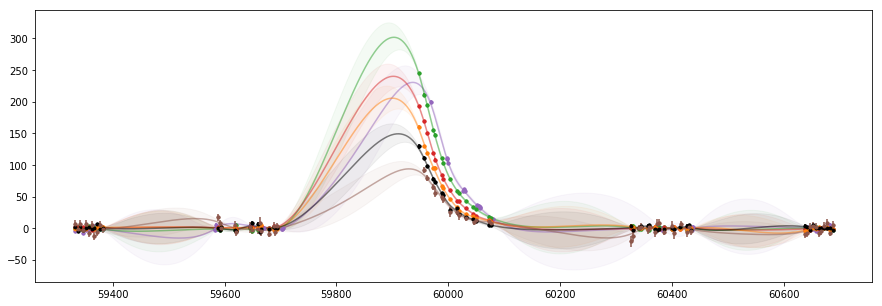

In [12]:
object_id = 4173
passband = 0
fit_predict_celerite(train, object_id)

class 15
class 15 object_id 4173


/home/jfpuget/anaconda3/envs/pg/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Final log-likelihood: -0.85 4.38 5.01 -6.01 -371.26 
Final log-likelihood: -0.81 4.69 5.41 -5.87 -140.83 
Final log-likelihood: -0.98 4.45 5.37 -6.25 -113.20 
Final log-likelihood: -1.24 4.26 5.27 -4.96 -28.92 
Final log-likelihood: -1.65 3.87 4.97 -3.87 -9.73 
Final log-likelihood: -2.61 3.44 4.79 -7.27 -5.22 


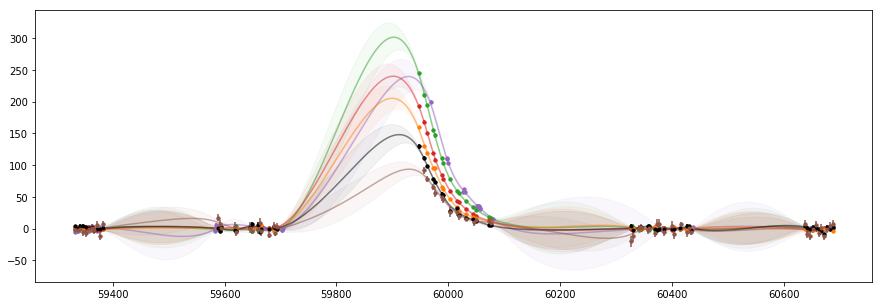

class 15 object_id 23116
Final log-likelihood: -5.05 2.61 4.20 -1.45 -99.94 
Final log-likelihood: -3.14 2.95 4.41 -7.54 -48.28 
Final log-likelihood: -3.37 2.94 4.52 -6.57 -63.70 
Final log-likelihood: -3.88 2.79 4.53 -1.78 -21.90 
Final log-likelihood: -4.82 2.58 4.27 -0.97 -9.78 
Final log-likelihood: -5.96 2.46 4.23 -10.98 -2.31 


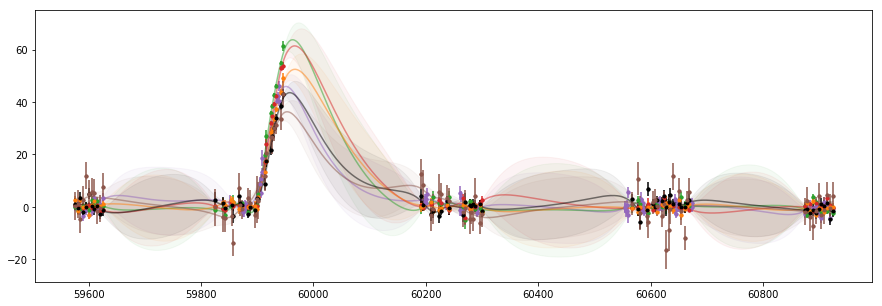

class 15 object_id 97406
Final log-likelihood: -6.63 2.40 4.87 -13.17 -0.88 
Final log-likelihood: -1.92 3.84 4.88 -4.19 -137.78 
Final log-likelihood: -2.45 3.45 4.85 -4.23 -60.03 
Final log-likelihood: -3.66 3.06 4.72 -6.17 -6.80 
Final log-likelihood: -4.93 2.63 4.60 -8.58 -16.32 
Final log-likelihood: -6.41 0.73 8.42 2.94 -4.79 


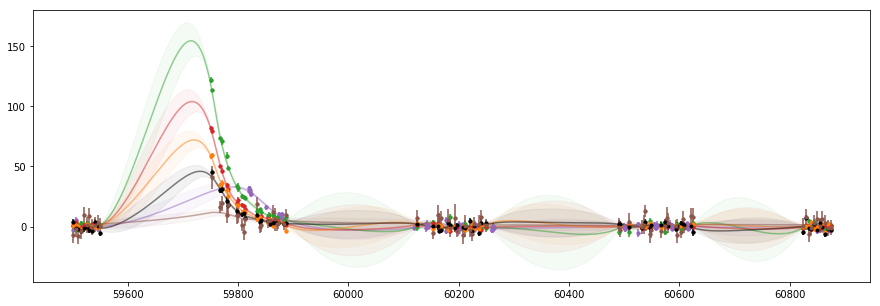

class 15 object_id 113669
Final log-likelihood: -1.72 3.79 4.01 -4.01 -943.77 
Final log-likelihood: -1.72 3.61 4.26 -5.57 -847.42 
Final log-likelihood: -2.06 3.34 4.23 -8.08 -688.26 
Final log-likelihood: -3.09 6.44 6.33 14.59 -184.22 
Final log-likelihood: -3.29 2.89 4.13 -8.85 -8.56 
Final log-likelihood: -4.38 -4.43 15.00 5.63 -4.78 


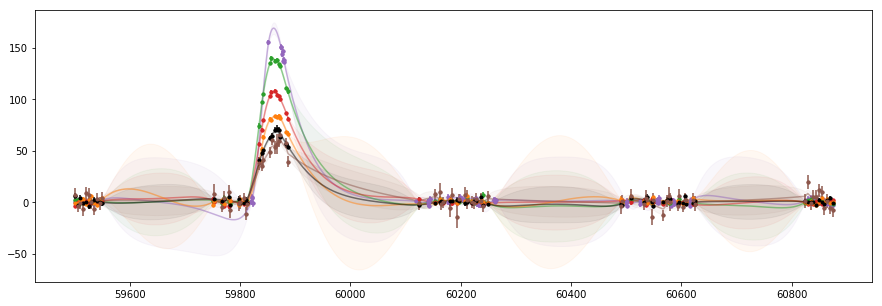

class 15 object_id 133234
Final log-likelihood: -23.33 -6.79 1.39 -0.06 -5.32 
Final log-likelihood: -14.18 -7.61 -15.00 1.76 -4.53 
Final log-likelihood: -15.07 0.51 4.23 -0.48 -5.14 
Final log-likelihood: -22.49 -3.17 -0.63 -0.34 1.76 
Final log-likelihood: -21.51 0.07 1.91 -0.05 -1.39 
Final log-likelihood: -13.45 0.45 -1.37 -0.30 1.47 


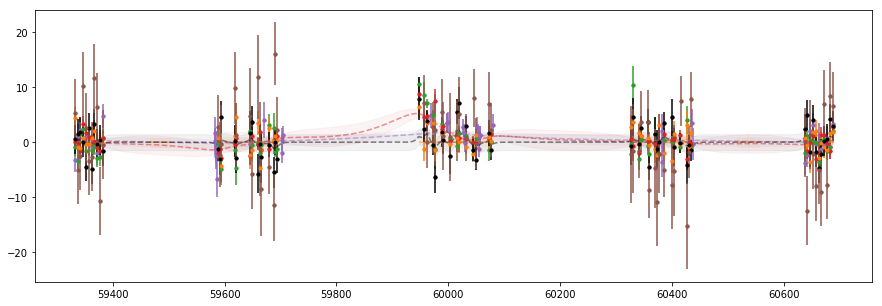

class 42
class 42 object_id 730
Final log-likelihood: -32.53 -7.45 -0.38 -12.74 0.92 
Final log-likelihood: -22.28 -11.75 0.14 -1.86 -2.85 
Final log-likelihood: -7.23 1.93 4.86 -9.78 -15.42 
Final log-likelihood: -5.39 2.34 4.76 -9.31 -10.87 
Final log-likelihood: -4.82 2.58 4.75 -9.95 -18.91 
Final log-likelihood: -5.39 2.62 4.50 0.68 -1.83 


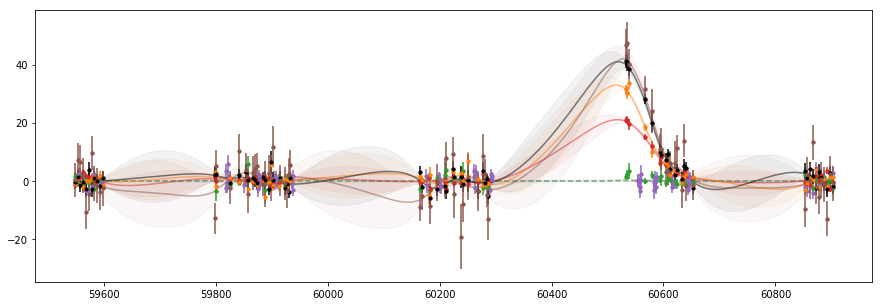

class 42 object_id 1632
Final log-likelihood: -33.95 -6.13 0.79 -1.84 -1.96 
Final log-likelihood: -28.21 -10.84 0.19 -10.96 -0.01 
Final log-likelihood: -32.10 -13.04 0.04 -12.21 -1.47 
Final log-likelihood: -22.70 0.38 4.65 -13.18 -5.67 
Final log-likelihood: -14.83 1.27 4.93 -13.48 -4.24 
Final log-likelihood: -7.79 1.87 5.11 -10.37 0.88 


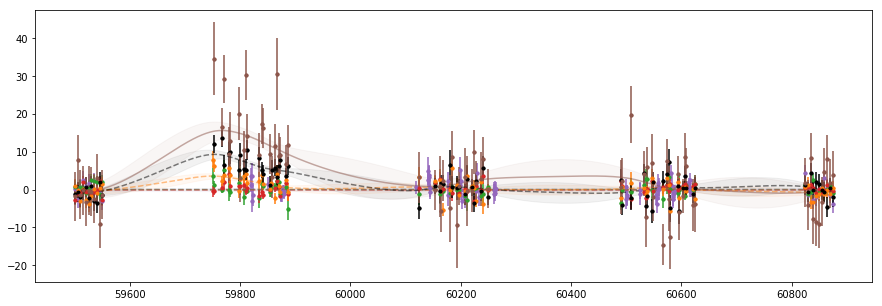

class 42 object_id 2103
Final log-likelihood: -2.82 -7.35 -5.10 5.60 -3.71 
Final log-likelihood: -1.54 3.54 2.72 -6.30 -686.22 
Final log-likelihood: -2.17 3.35 3.11 1.59 -436.22 
Final log-likelihood: -2.26 3.35 3.22 3.83 -120.67 
Final log-likelihood: -2.08 3.44 3.30 -2.22 -29.06 
Final log-likelihood: -2.26 -3.64 5.83 6.88 -4.05 


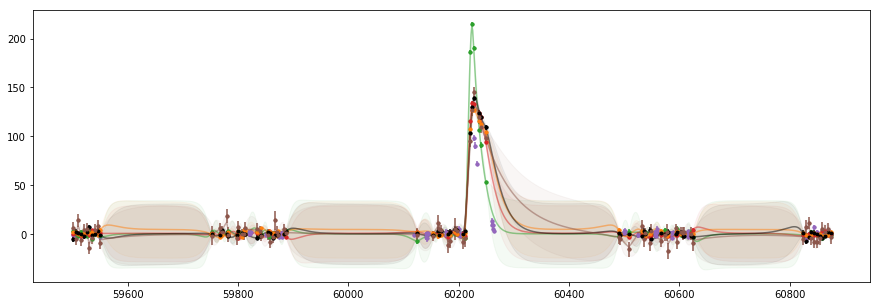

class 42 object_id 2300
Final log-likelihood: -30.96 -8.13 -0.27 -12.64 0.54 
Final log-likelihood: -29.53 -13.62 -0.00 -2.27 -0.27 
Final log-likelihood: -37.40 -15.00 0.17 -0.48 -4.57 
Final log-likelihood: -9.23 1.60 4.85 2.08 -5.28 
Final log-likelihood: -9.50 1.80 4.92 0.04 -1.28 
Final log-likelihood: -7.50 1.78 5.28 -7.13 -2.96 


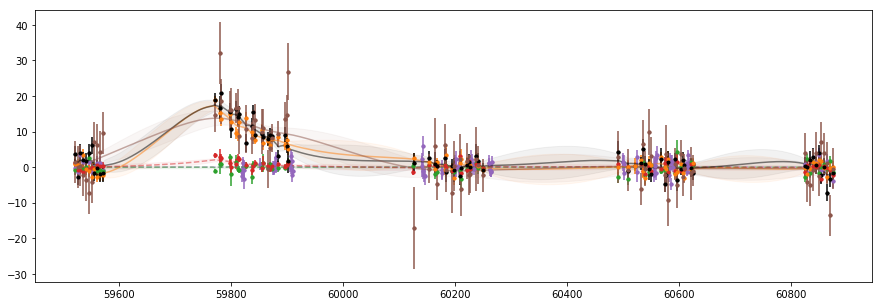

class 42 object_id 3285
Final log-likelihood: -4.91 1.96 4.03 -9.08 1.44 
Final log-likelihood: -1.90 3.51 2.43 2.67 -92.52 
Final log-likelihood: -2.14 3.32 2.87 1.89 -106.14 
Final log-likelihood: -2.43 3.21 2.96 2.81 -47.02 
Final log-likelihood: -2.19 3.28 3.44 -5.84 -6.79 
Final log-likelihood: -2.25 3.27 3.57 4.33 -2.91 


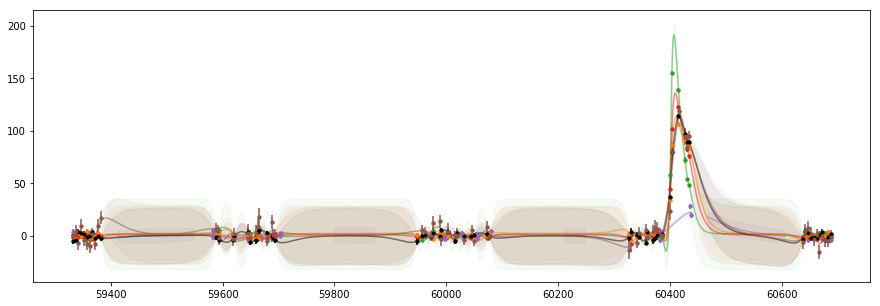

class 52
class 52 object_id 10757
Final log-likelihood: -3.22 2.68 3.14 -9.05 -115.95 
Final log-likelihood: -1.27 3.83 3.41 -8.06 -805.26 
Final log-likelihood: -1.12 4.07 3.60 -7.22 -1000.00 
Final log-likelihood: -1.18 4.01 3.66 -3.31 -1000.00 
Final log-likelihood: -1.17 3.97 3.66 -7.22 -814.79 
Final log-likelihood: -1.27 4.01 3.72 -7.08 -7.27 


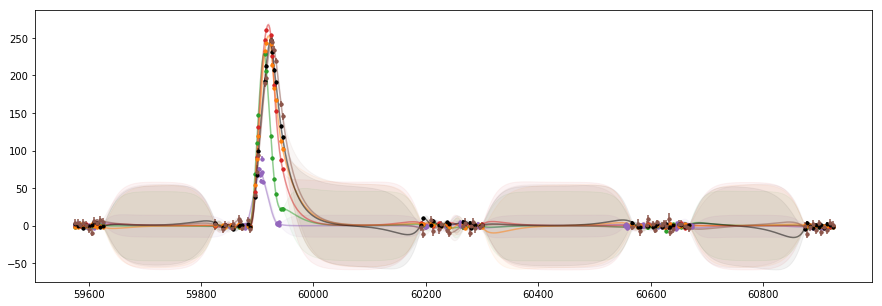

class 52 object_id 11773
Final log-likelihood: -23.86 -3.48 -1.96 -1.34 3.14 
Final log-likelihood: -27.39 0.21 5.01 -2.02 -3.95 
Final log-likelihood: -6.08 2.07 4.77 -2.48 -13.37 
Final log-likelihood: -4.04 2.66 4.88 -4.25 -6.31 
Final log-likelihood: -4.72 2.51 4.66 2.13 -4.23 
Final log-likelihood: -6.10 2.06 4.58 3.17 -2.27 


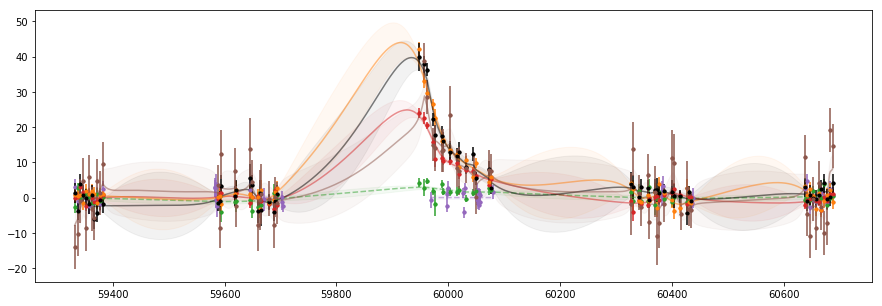

class 52 object_id 13138
Final log-likelihood: -28.93 0.30 4.75 -13.87 -3.78 
Final log-likelihood: -0.45 6.02 4.85 0.51 -489.80 
Final log-likelihood: -0.41 5.51 4.44 -0.07 -1000.00 
Final log-likelihood: -0.50 5.04 3.90 7.09 -1000.00 
Final log-likelihood: -0.47 5.28 4.68 0.92 -364.02 
Final log-likelihood: -0.44 5.16 3.72 -1.47 -11.48 


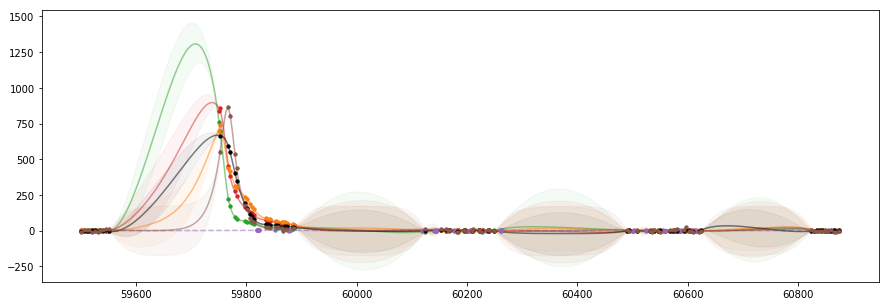

class 52 object_id 14279
Final log-likelihood: -36.84 -6.31 0.13 -1.58 -1.10 
Final log-likelihood: -3.37 -7.56 5.71 5.51 -5.29 
Final log-likelihood: -2.13 3.15 3.89 -5.42 -57.62 
Final log-likelihood: -1.81 3.33 3.69 3.33 -120.51 
Final log-likelihood: -2.13 3.17 3.46 3.61 -24.15 
Final log-likelihood: -2.70 -1.57 7.73 6.32 -5.10 


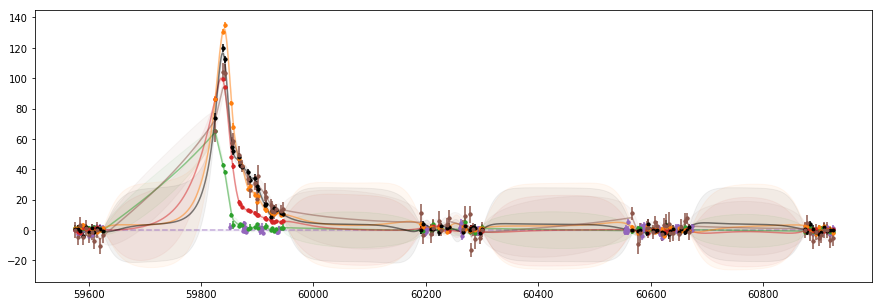

class 52 object_id 15718
Final log-likelihood: -8.06 -5.07 9.07 3.14 -3.19 
Final log-likelihood: -3.42 2.51 3.14 -10.55 -16.00 
Final log-likelihood: -2.90 2.72 3.40 -5.50 -64.29 
Final log-likelihood: -3.21 2.64 3.25 -5.81 -23.08 
Final log-likelihood: -3.71 2.60 3.62 -11.29 -0.03 
Final log-likelihood: -4.86 2.58 3.44 0.28 1.26 


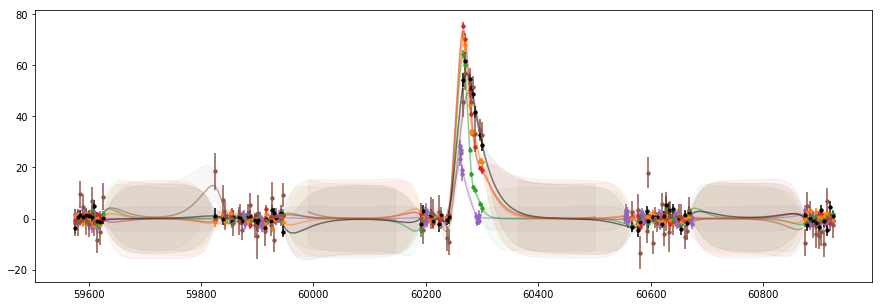

class 62
class 62 object_id 3910
Final log-likelihood: -42.65 -4.50 -1.37 -0.54 3.47 
Final log-likelihood: -6.98 1.25 2.01 -13.24 -1.32 
Final log-likelihood: -3.88 -6.78 -10.69 4.36 -2.41 
Final log-likelihood: -2.87 2.58 2.00 -5.52 -9.86 
Final log-likelihood: -2.69 2.94 -5.62 0.18 0.95 
Final log-likelihood: -2.21 3.06 2.16 -4.90 -4.07 


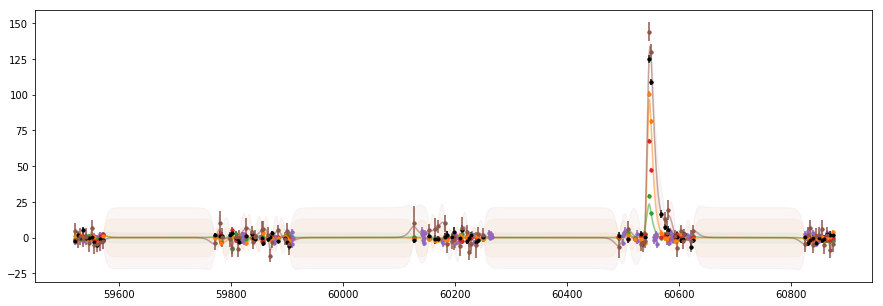

class 62 object_id 7703
Final log-likelihood: -27.18 -6.54 0.45 -1.22 -1.27 
Final log-likelihood: -4.04 2.71 4.92 -8.41 -8.75 
Final log-likelihood: -1.69 3.80 5.32 -4.54 -308.95 
Final log-likelihood: -1.41 4.25 5.04 -2.69 -128.78 
Final log-likelihood: -1.78 4.09 4.79 -12.52 -1.71 
Final log-likelihood: -1.83 3.93 3.90 -6.20 -10.67 


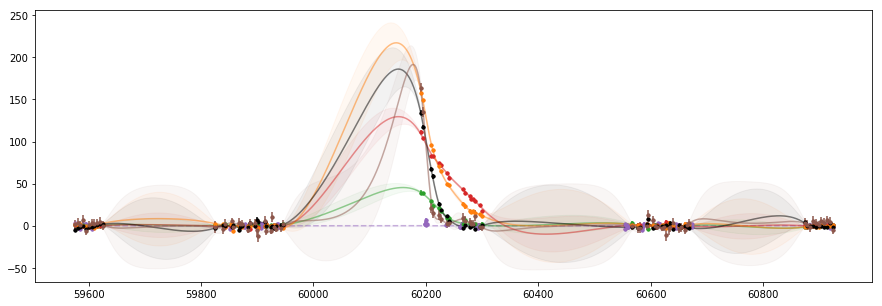

class 62 object_id 11770
Final log-likelihood: -28.94 -3.78 -1.75 -0.27 3.82 
Final log-likelihood: -20.33 0.23 1.42 -0.76 -4.68 
Final log-likelihood: -6.74 1.49 1.73 -11.54 0.86 
Final log-likelihood: -4.09 -15.00 8.00 4.24 -2.24 
Final log-likelihood: -3.13 -3.82 14.07 5.06 -2.51 
Final log-likelihood: -2.75 2.79 2.01 -6.98 -2.27 


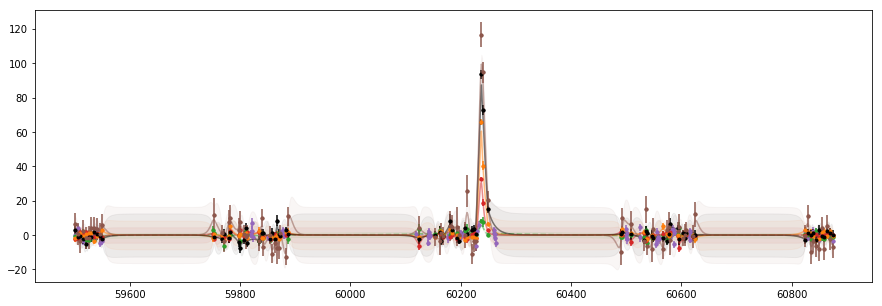

class 62 object_id 17370
Final log-likelihood: -5.34 2.58 4.47 -0.51 4.68 
Final log-likelihood: -2.49 3.01 3.96 -4.79 -13.28 
Final log-likelihood: -1.61 3.65 4.32 -8.42 -250.37 
Final log-likelihood: -1.37 3.98 4.49 -8.10 -508.35 
Final log-likelihood: -1.26 4.09 4.54 -7.67 -297.07 
Final log-likelihood: -1.29 4.11 4.48 -9.21 -3.01 


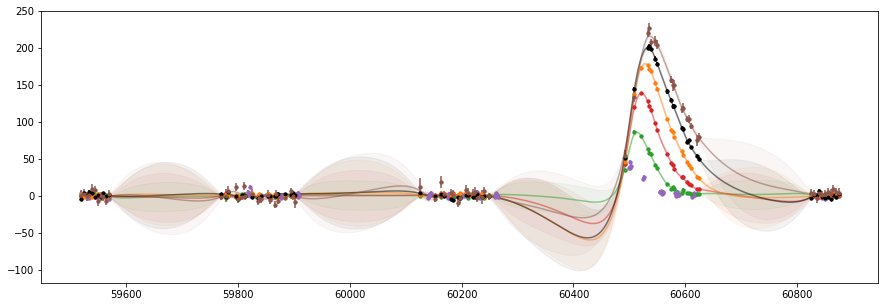

class 62 object_id 18645
Final log-likelihood: -38.98 -8.22 -0.53 -12.22 1.43 
Final log-likelihood: -22.18 -14.97 -0.04 -3.45 1.74 
Final log-likelihood: -18.30 -8.45 0.29 0.37 -4.74 
Final log-likelihood: -11.88 1.28 4.47 -4.81 1.31 
Final log-likelihood: -24.77 -6.07 -0.46 -11.30 0.63 
Final log-likelihood: -19.08 -5.63 -0.10 -10.24 0.20 


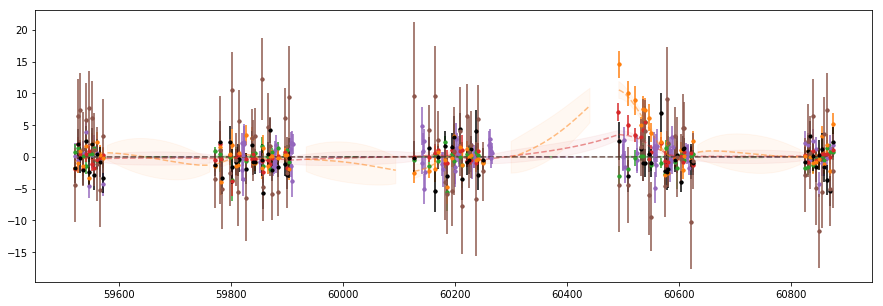

class 67
class 67 object_id 2922
Final log-likelihood: -12.74 1.08 4.36 1.22 -1.44 
Final log-likelihood: -3.61 2.86 4.45 -7.45 -25.77 
Final log-likelihood: -0.91 4.97 4.92 -5.34 -14.26 
Final log-likelihood: -0.61 5.54 4.98 -11.24 -4.57 
Final log-likelihood: -0.63 5.42 4.91 -4.23 -9.58 
Final log-likelihood: -0.85 5.00 4.65 -8.82 0.26 


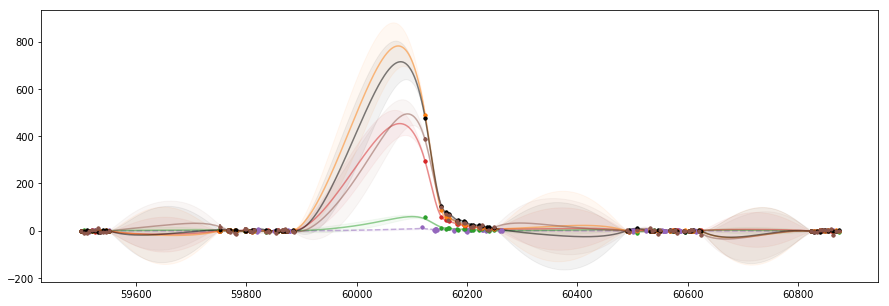

class 67 object_id 3041
Final log-likelihood: -48.50 -6.70 -0.77 -12.16 0.78 
Final log-likelihood: -28.17 -8.91 0.21 -0.13 -4.49 
Final log-likelihood: -8.62 1.64 4.57 -9.88 -5.28 
Final log-likelihood: -10.72 1.64 4.76 -0.20 -0.16 
Final log-likelihood: -7.41 2.18 4.76 -2.14 0.66 
Final log-likelihood: -6.29 2.15 4.70 -0.36 -2.35 


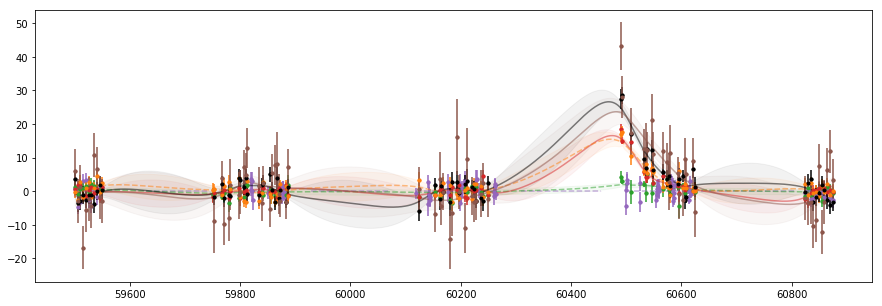

class 67 object_id 19154
Final log-likelihood: -35.83 0.11 3.00 -14.81 0.24 
Final log-likelihood: -5.66 1.87 2.43 -12.09 -4.30 
Final log-likelihood: -2.17 3.18 2.88 -9.28 -239.26 
Final log-likelihood: -1.65 3.72 3.06 -7.79 -294.55 
Final log-likelihood: -1.64 3.73 3.14 -6.64 -49.43 
Final log-likelihood: -1.94 -4.06 9.02 7.55 -4.30 


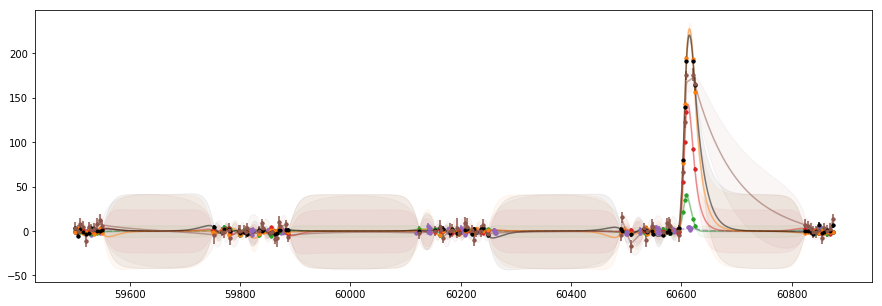

class 67 object_id 28636
Final log-likelihood: -20.49 0.47 1.70 -0.23 -4.35 
Final log-likelihood: -2.22 3.06 2.63 -5.63 -329.73 
Final log-likelihood: -0.99 4.13 3.04 -5.62 -1000.00 
Final log-likelihood: -0.74 4.55 3.18 -5.38 -1000.00 
Final log-likelihood: -0.84 4.38 3.10 -5.56 -941.30 
Final log-likelihood: -1.05 4.24 3.12 -4.01 -35.47 


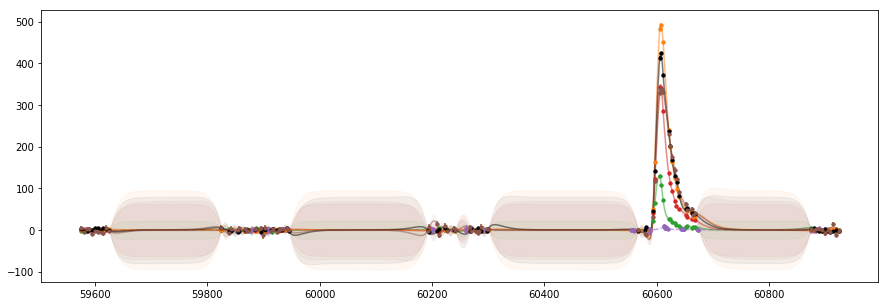

class 67 object_id 34437
Final log-likelihood: -18.93 -1.14 0.61 -0.99 2.66 
Final log-likelihood: -23.72 -5.54 0.06 -0.54 -4.90 
Final log-likelihood: -7.21 -3.13 15.00 3.20 -5.00 
Final log-likelihood: -3.23 3.00 4.34 -8.31 -12.04 
Final log-likelihood: -2.69 3.24 4.45 -8.44 -4.63 
Final log-likelihood: -4.19 2.59 3.77 2.04 1.59 


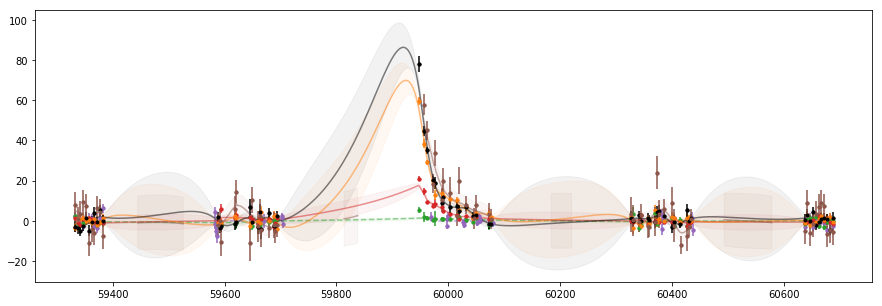

class 90
class 90 object_id 745
Final log-likelihood: -12.63 1.51 4.55 -7.51 -5.52 
Final log-likelihood: -1.52 -2.70 10.91 7.65 -5.57 
Final log-likelihood: -1.04 4.55 5.04 -3.63 -14.38 
Final log-likelihood: -1.16 4.35 5.10 -6.22 -10.32 
Final log-likelihood: -1.34 4.16 4.86 -6.05 -14.22 
Final log-likelihood: -2.00 3.66 4.92 2.34 -0.15 


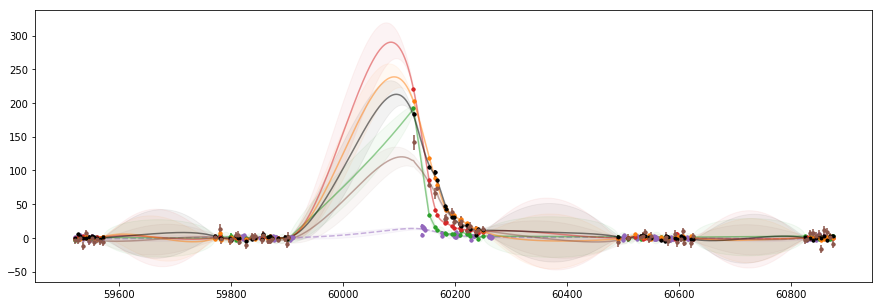

class 90 object_id 1124
Final log-likelihood: -34.90 -7.32 1.53 -0.30 -6.98 
Final log-likelihood: -4.92 2.49 5.00 -9.00 -7.87 
Final log-likelihood: -1.95 3.83 5.17 -5.23 -86.25 
Final log-likelihood: -1.75 4.11 4.91 -3.65 -53.88 
Final log-likelihood: -1.75 4.10 4.80 -7.61 -8.88 
Final log-likelihood: -2.77 3.51 4.52 2.45 1.58 


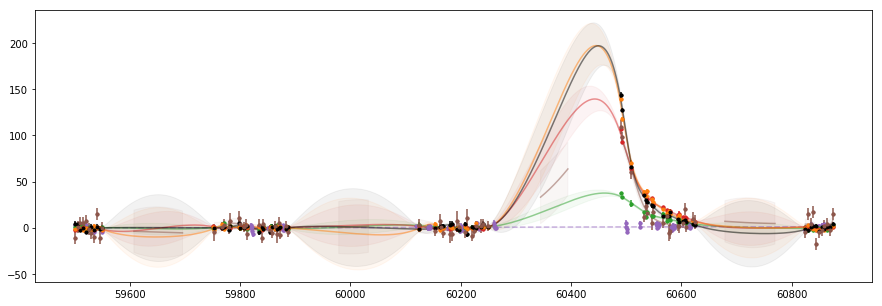

class 90 object_id 1598
Final log-likelihood: -1.26 4.46 3.02 -3.50 -820.31 
Final log-likelihood: -0.31 6.10 3.79 0.58 -18.67 
Final log-likelihood: -0.44 -3.84 0.11 10.93 -4.48 
Final log-likelihood: -0.42 5.51 3.55 0.75 -73.05 
Final log-likelihood: -0.55 5.04 3.25 -3.21 -65.53 
Final log-likelihood: -0.60 5.20 3.67 -0.90 -11.12 


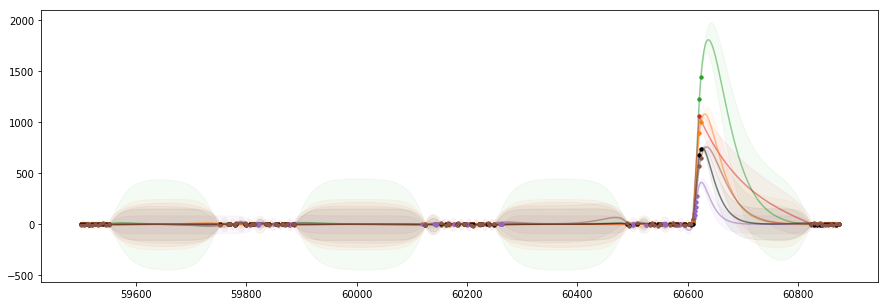

class 90 object_id 1920
Final log-likelihood: -6.19 1.61 2.86 0.00 -2.31 
Final log-likelihood: -1.36 3.66 3.20 -8.10 -137.98 
Final log-likelihood: -1.15 3.97 3.47 -6.00 -356.88 
Final log-likelihood: -1.17 3.96 3.52 -4.65 -122.11 
Final log-likelihood: -1.42 3.80 3.38 3.88 -28.50 
Final log-likelihood: -1.87 -2.44 4.94 7.03 -3.99 


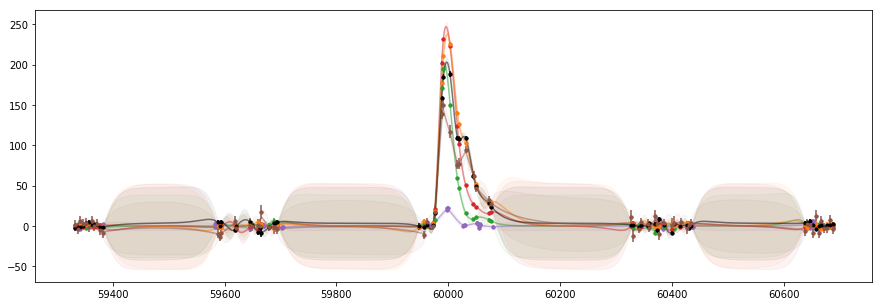

class 90 object_id 2072
Final log-likelihood: -29.52 -5.61 -1.12 -0.82 2.75 
Final log-likelihood: -11.53 1.22 4.74 -11.81 -7.04 
Final log-likelihood: -7.34 1.88 4.93 -5.68 -9.24 
Final log-likelihood: -10.31 -5.46 14.98 2.80 -5.31 
Final log-likelihood: -10.63 -3.59 12.48 2.89 -5.28 
Final log-likelihood: -13.25 1.41 4.51 -12.29 -6.12 


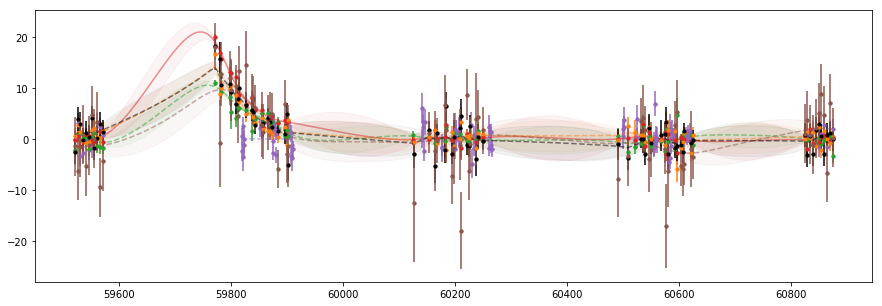

In [13]:
for class_ in [15, 42, 52, 62, 67, 90]:
    print('class', class_)
    for object_id in train[train.target==class_].object_id.unique()[:5]:
        print('class', class_, 'object_id', object_id)
        fit_predict_celerite(train, object_id)

class 64
class 64 object_id 62187
Final log-likelihood: -34.21 -5.76 0.02 -1.37 -2.90 


/home/jfpuget/anaconda3/envs/pg/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Final log-likelihood: -36.70 -11.85 0.09 -3.39 -4.27 
Final log-likelihood: -7.37 1.20 2.21 -1.38 -17.63 
Final log-likelihood: -5.81 1.27 -4.17 0.48 1.43 
Final log-likelihood: -8.62 -4.34 1.74 0.19 -1.92 
Final log-likelihood: -17.28 -5.60 -0.15 -10.22 0.36 


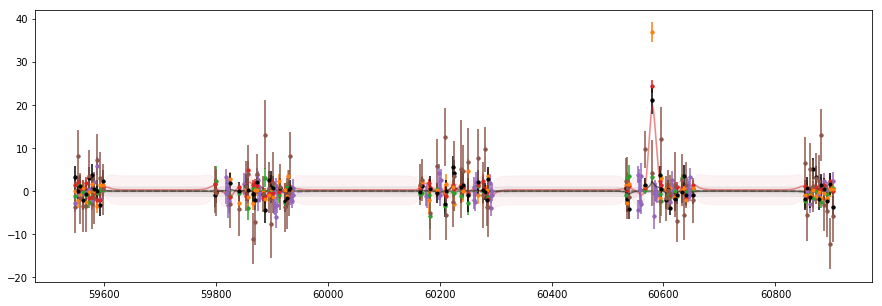

class 64 object_id 139362
Final log-likelihood: -30.58 -2.78 -2.08 -0.44 3.15 
Final log-likelihood: -18.93 -8.32 0.13 -1.32 -2.80 
Final log-likelihood: -6.56 1.40 2.11 -5.39 -0.60 
Final log-likelihood: -4.65 1.88 2.07 -0.95 -0.69 
Final log-likelihood: -12.47 0.49 0.86 -11.63 0.13 
Final log-likelihood: -10.97 1.15 2.02 -13.28 -5.60 


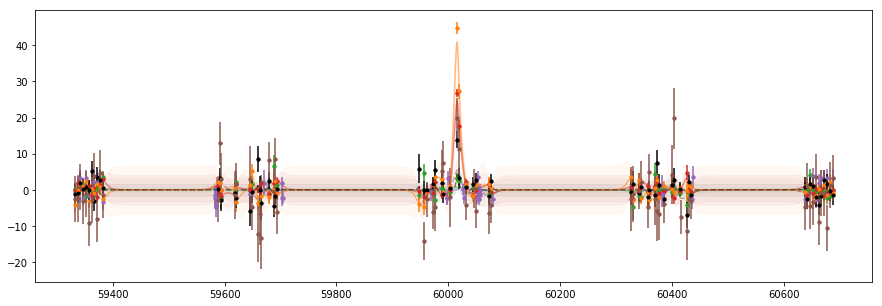

class 64 object_id 1573501
Final log-likelihood: -0.63 -0.00 0.00 -0.00 -0.00 
Final log-likelihood: -1.89 2.24 -2.32 1.27 2.44 
Final log-likelihood: -1.29 3.18 1.90 -6.06 -2.10 
Final log-likelihood: -2.49 -4.41 0.01 -8.03 0.03 
Final log-likelihood: -0.41 4.77 3.02 -7.23 -1.67 
Final log-likelihood: -2.55 2.84 0.72 0.51 -1.02 


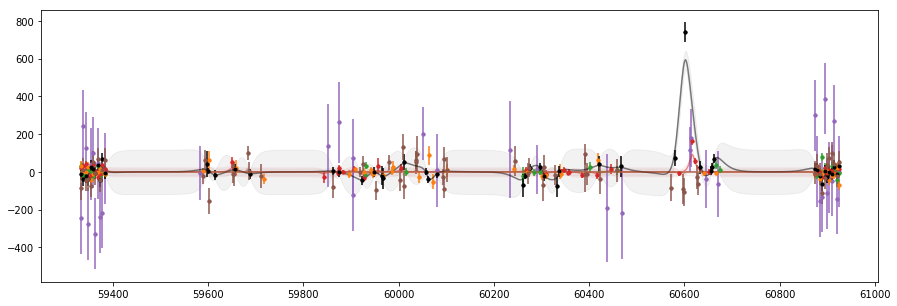

class 64 object_id 3572446
Final log-likelihood: -4.88 0.99 -2.20 -0.40 1.66 
Final log-likelihood: -2.57 2.17 3.30 1.92 1.62 
Final log-likelihood: -1.22 3.10 -0.00 2.21 0.00 
Final log-likelihood: -0.34 -5.82 0.46 10.36 -4.68 
Final log-likelihood: -6.22 -4.37 0.06 -7.95 -0.36 
Final log-likelihood: -4.36 -4.06 -0.04 -7.32 0.07 


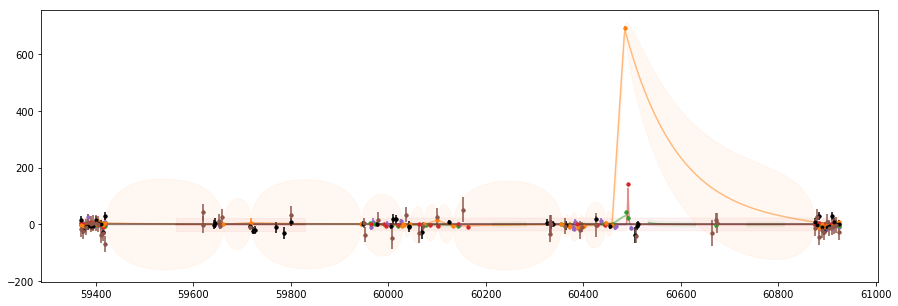

class 64 object_id 4311960
Final log-likelihood: -5.92 0.88 0.29 -9.85 -2.44 
Final log-likelihood: -9.97 -10.12 0.11 0.33 -5.61 
Final log-likelihood: -4.66 0.08 -4.03 0.46 2.41 
Final log-likelihood: -8.44 1.31 -0.64 -7.93 3.57 
Final log-likelihood: -0.82 3.48 0.64 1.43 -0.03 
Final log-likelihood: -2.69 -3.10 -1.29 -5.40 1.71 


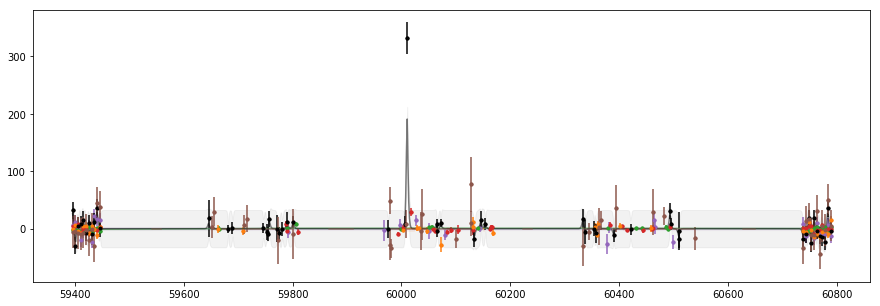

class 88
class 88 object_id 713
Final log-likelihood: -16.04 -12.37 3.94 3.38 -5.31 
Final log-likelihood: -18.80 -4.58 5.76 3.10 -4.95 
Final log-likelihood: -15.31 -3.15 6.70 3.08 -5.09 
Final log-likelihood: -16.93 1.52 5.32 1.40 -2.28 
Final log-likelihood: -20.50 1.45 4.99 2.01 -3.15 
Final log-likelihood: -16.66 -3.02 0.57 2.91 -5.11 


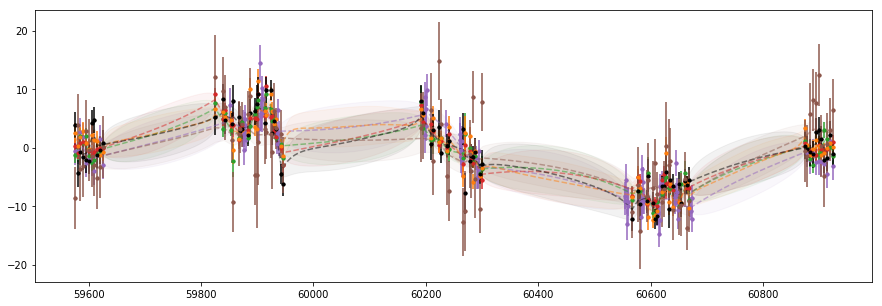

class 88 object_id 3489
Final log-likelihood: -7.57 1.53 5.06 -0.91 -2.32 
Final log-likelihood: -13.08 1.56 4.94 1.39 -2.63 
Final log-likelihood: -14.94 1.66 5.51 0.33 -2.30 
Final log-likelihood: -15.55 1.52 5.38 -14.98 1.40 
Final log-likelihood: -17.50 1.49 5.15 -6.28 -3.58 
Final log-likelihood: -15.81 1.50 4.38 1.29 -1.26 


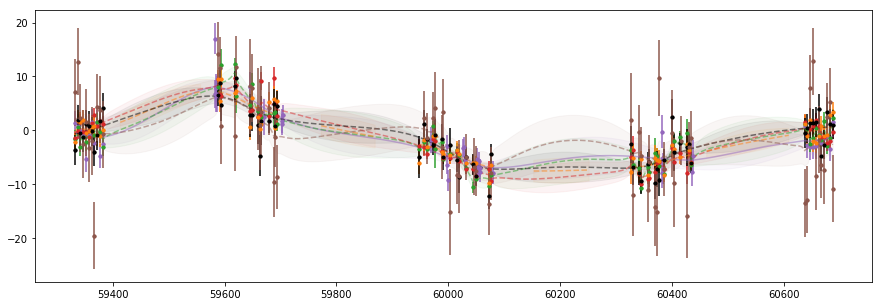

class 88 object_id 4088
Final log-likelihood: -59.04 3.42 3.37 7.40 -1000.00 
Final log-likelihood: -93.91 3.38 3.18 7.57 -1000.00 
Final log-likelihood: -107.20 3.24 3.22 7.29 -1000.00 
Final log-likelihood: -128.86 3.37 3.21 7.54 -902.97 
Final log-likelihood: -58.71 3.38 3.44 7.51 -343.39 
Final log-likelihood: -29.28 3.82 4.36 7.84 -26.19 


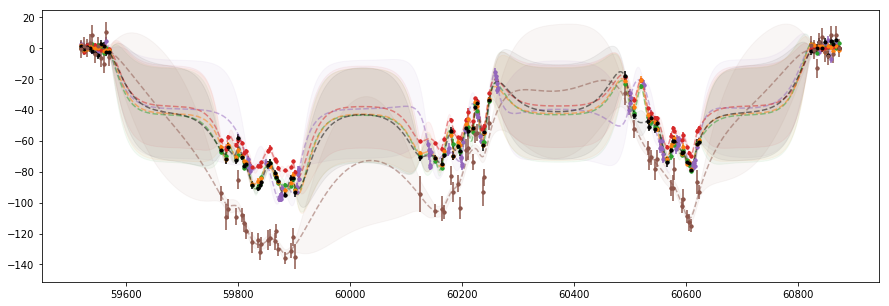

class 88 object_id 7315
Final log-likelihood: -0.53 6.37 2.02 10.25 -1000.00 
Final log-likelihood: -0.44 6.37 2.75 9.90 -1000.00 
Final log-likelihood: -0.40 6.50 2.76 10.24 -1000.00 
Final log-likelihood: -0.30 6.84 2.77 10.99 -1000.00 
Final log-likelihood: -0.31 6.79 2.75 11.16 -1000.00 
Final log-likelihood: -0.28 6.87 2.78 11.28 -335.96 


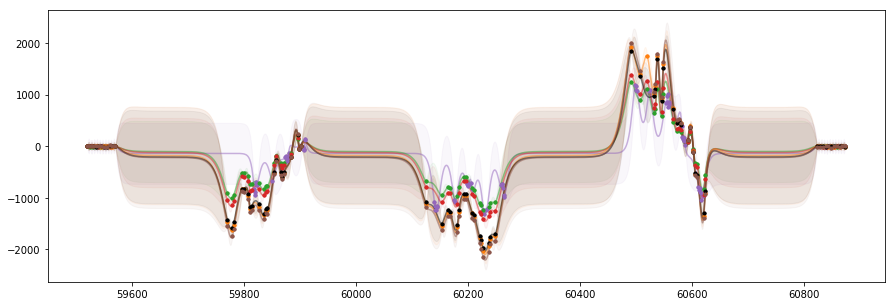

class 88 object_id 7409
Final log-likelihood: -26.78 -7.86 2.14 0.07 -4.76 
Final log-likelihood: -10.81 1.74 5.07 2.50 -4.14 
Final log-likelihood: -9.08 2.16 3.75 2.97 -12.57 
Final log-likelihood: -8.60 -14.81 11.92 4.63 -5.21 
Final log-likelihood: -9.60 2.21 4.26 3.34 -13.50 
Final log-likelihood: -9.21 2.10 4.82 2.18 0.22 


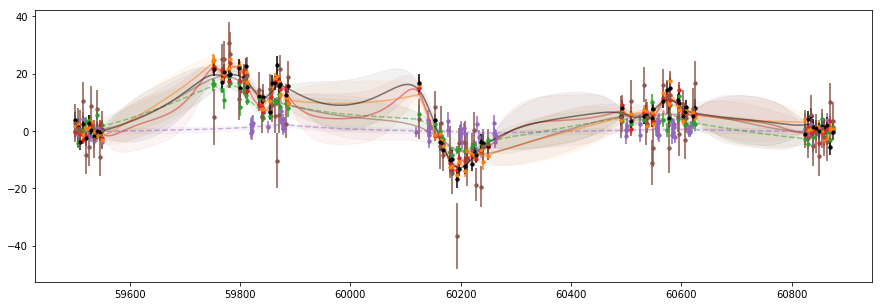

class 95
class 95 object_id 3423
Final log-likelihood: -24.86 -4.93 -0.15 -1.71 -4.85 
Final log-likelihood: -24.75 -8.45 0.02 -1.52 -1.83 
Final log-likelihood: -18.29 -10.09 0.25 -0.55 -4.68 
Final log-likelihood: -7.85 1.69 4.80 -6.07 -11.17 
Final log-likelihood: -5.43 2.43 4.76 -7.81 -4.15 
Final log-likelihood: -7.15 2.40 5.00 -10.55 -2.12 


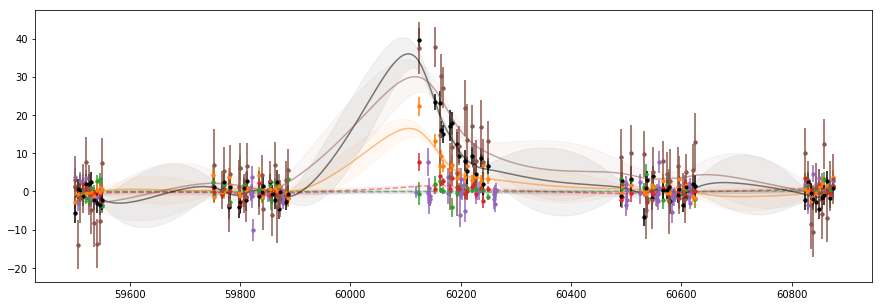

class 95 object_id 10321
Final log-likelihood: -2.47 3.46 4.46 -6.79 -1000.00 
Final log-likelihood: -1.10 4.14 4.73 -5.55 -1000.00 
Final log-likelihood: -0.72 4.66 4.98 -5.70 -1000.00 
Final log-likelihood: -0.70 4.77 5.02 -5.11 -1000.00 
Final log-likelihood: -0.71 4.78 5.03 -3.36 -1000.00 
Final log-likelihood: -0.86 4.68 4.86 -1.18 -47.59 


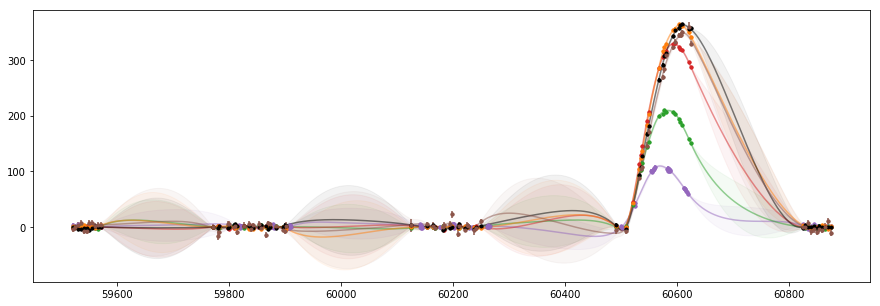

class 95 object_id 14553
Final log-likelihood: -1.44 4.03 4.15 -3.21 -1000.00 
Final log-likelihood: -1.09 4.23 4.17 -5.93 -1000.00 
Final log-likelihood: -0.88 4.51 4.33 -6.15 -1000.00 
Final log-likelihood: -0.97 4.40 4.31 -5.52 -931.84 
Final log-likelihood: -1.04 4.45 4.59 -0.86 -375.80 
Final log-likelihood: -1.28 4.36 4.51 -5.08 -6.92 


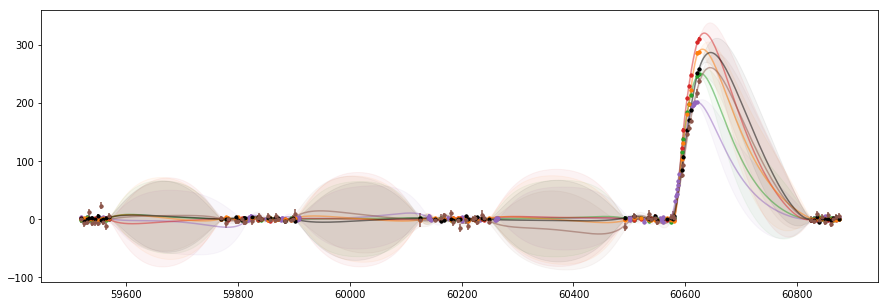

class 95 object_id 23539
Final log-likelihood: -0.31 5.77 4.42 -3.76 -1000.00 
Final log-likelihood: -0.22 6.25 4.73 -3.15 -634.71 
Final log-likelihood: -0.22 6.27 4.89 -3.15 -719.06 
Final log-likelihood: -0.23 6.22 4.96 -2.87 -722.59 
Final log-likelihood: -0.25 6.16 4.99 -2.99 -695.29 
Final log-likelihood: -0.28 6.02 4.87 -2.83 -202.96 


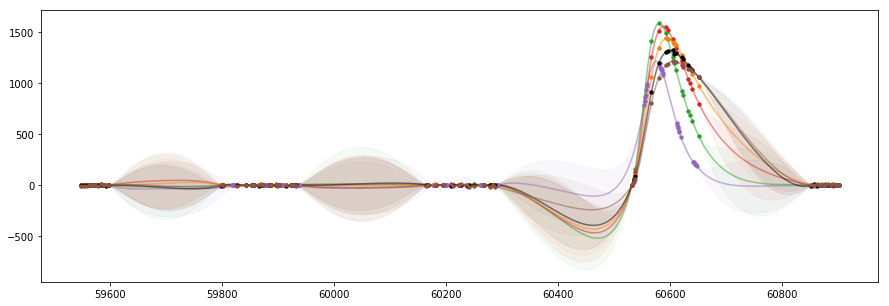

class 95 object_id 31569
Final log-likelihood: -1.23 4.38 4.64 -6.21 -496.71 
Final log-likelihood: -0.99 4.29 4.00 -7.18 -1000.00 
Final log-likelihood: -0.86 4.49 4.15 -5.64 -1000.00 
Final log-likelihood: -0.98 4.40 4.16 -1.29 -1000.00 
Final log-likelihood: -1.12 4.29 4.14 -4.48 -714.81 
Final log-likelihood: -1.32 4.22 4.15 -3.58 -9.76 


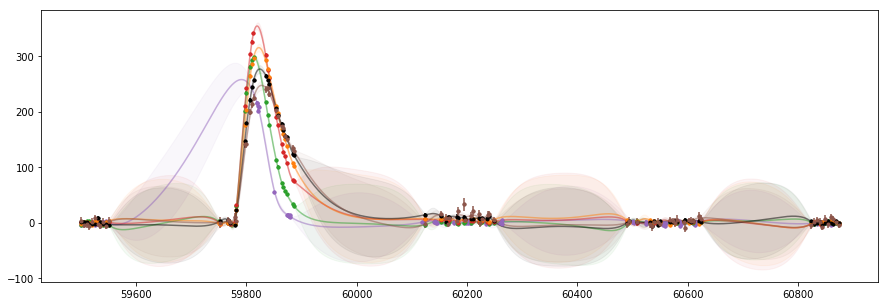

In [14]:
for class_ in [64, 88, 95]:
    print('class', class_)
    for object_id in train[train.target==class_].object_id.unique()[:5]:
        print('class', class_, 'object_id', object_id)
        fit_predict_celerite(train, object_id)